# Ikeda for many ships

In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
from pyscores2.indata import Indata
from pyscores2.runScores2 import Calculation
from pyscores2.output import OutputFile
from pyscores2 import TDPError
import pyscores2
from rolldecayestimators.ikeda import Ikeda, IkedaR
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import subprocess
from rolldecayestimators import measure
from copy import deepcopy

In [4]:
df_all_sections_id = pd.read_csv('../data/external/all_sections.csv', sep=';')
df_all_sections_id.head()

,b,area,t,x,SHIP,loading_condition_id
0,0.00,0.0,0.0,0.00,68,NaN
1,26.86,19.5,6.6,8.61,68,NaN
2,28.17,54.7,6.6,17.22,68,NaN
3,28.40,96.0,6.6,25.83,68,NaN
4,28.40,129.4,6.6,34.44,68,NaN


In [5]:
section_groups=df_all_sections_id.groupby(by='loading_condition_id')

In [6]:
loading_condition_ids = df_all_sections_id['loading_condition_id'].unique()
mask=pd.notnull(loading_condition_ids)
loading_condition_ids=loading_condition_ids[mask]

In [7]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.99, 
                             exclude_table_name='rolldecay_exclude')

df_rolldecay['g'] = 9.81
df_rolldecay['V'] = df_rolldecay['ship_speed']*1.852/3.6     
df_rolldecay['Fn'] = df_rolldecay['V']/np.sqrt(df_rolldecay['lpp']*df_rolldecay['g'])

In [8]:
mask=df_rolldecay['loading_condition_id'].isin(loading_condition_ids)
df=df_rolldecay.loc[mask].copy()

In [9]:
df['BKB'].fillna(0, inplace=True)

In [10]:
def create_ikeda(row, indata, output_file, fi_a):

    w = row.omega0
    scale_factor=row.scale_factor
    V = row.ship_speed*1.852/3.6/np.sqrt(scale_factor)
    R = 0.01*row.beam/scale_factor
    lBK=row.BKL/scale_factor
    bBK=row.BKB/scale_factor
    kg = row.kg/scale_factor
    
    ikeda = Ikeda.load_scoresII(V=V, w=w, fi_a=fi_a, indata=indata, output_file=output_file, 
                                scale_factor=scale_factor, BKL=lBK, BKB=bBK, kg=kg, sigma_limit=0.99)
        
    return ikeda

In [11]:
def calculate_ikeda(ikeda):

    output = pd.DataFrame()
    output['B_44_hat']   = ikeda.calculate_B44()
    output['B_W0_hat']   = float(ikeda.calculate_B_W0())
    output['B_W_hat']    = float(ikeda.calculate_B_W())
    output['B_F_hat']    = ikeda.calculate_B_F()
    output['B_E_hat']    = ikeda.calculate_B_E()
    output['B_BK_hat']   = ikeda.calculate_B_BK()
    output['B_L_hat']    = float(ikeda.calculate_B_L())
    output['Bw_div_Bw0'] = float(ikeda.calculate_Bw_div_Bw0())
    return output

In [12]:
def get_B_1_B2(s1,s2,fi_as:np.ndarray):    
    
    # Derive linear and quadratic part for all components:
    
    if isinstance(s1,pd.Series):
        result=pd.Series(name=row.name)
        columns = s1.index
    elif isinstance(s1,pd.DataFrame):
        result=pd.DataFrame()
        columns = s1.columns
    else:
        raise ValueError('s1 must be pd.Series or pd.DataFrame')
    
    x = fi_as*8*row.omega0/(3 * np.pi)
    B_2 = (s2 - s1) / (x[1] - x[0])
    B_1 = s1 - B_2 * x[0]
    
    # Save all of the component as one linear term: _1 and a quadratic term: _2
    
    
    for key in columns:
        new_name_1 = '%s_1' % key
        result[new_name_1] = s1[key]

        new_name_2 = '%s_2' % key
        result[new_name_2] = s2[key]
        
    return result

In [13]:
results = pd.DataFrame()
fi_as = np.deg2rad([1,10])
ikedas = {}
for run_name, row in df.iterrows():
    loading_condition_id=row['loading_condition_id']
    
    save_name='%s.in' % row.loading_condition_id
    save_path=os.path.join('scores',save_name)
    indata = Indata()
    if os.path.exists(save_path):
        indata.open(indataPath=save_path)
    else:
        continue
    
    #calculation = Calculation(outDataDirectory='scores/result')
    output_file_name = 'loading_condition_id_%i.out' % loading_condition_id
    output_file_path = os.path.join(r'scores/result', output_file_name)
    
    coefficients_file_name = 'loading_condition_id_%i-COEFF.out' % loading_condition_id
    coefficients_file_path = os.path.join(r'scores/result', coefficients_file_name)
    
    if os.path.exists(coefficients_file_path) and (os.path.getsize(coefficients_file_path) > 0):
        output_file = OutputFile(filePath=output_file_path)
    else:
        continue
    
    ikeda = create_ikeda(row=row, indata=indata, output_file=output_file, fi_a=fi_as)
    ikedas[run_name] = ikeda
    result_datas = ikeda.calculate()
    
    # Derive linear and quadratic part for all components:
    s1=result_datas.iloc[0]
    s2=result_datas.iloc[1]
    result = get_B_1_B2(s1=s1, s2=s2, fi_as=fi_as)
    result['id'] = run_name
    
    results=results.append(result)
    

c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0

In [14]:
results.head()

,B_44_hat_1,B_44_hat_2,B_BK_hat_1,B_BK_hat_2,B_E_hat_1,B_E_hat_2,B_F_hat_1,B_F_hat_2,B_L_hat_1,B_L_hat_2,B_W0_hat_1,B_W0_hat_2,B_W_hat_1,B_W_hat_2,Bw_div_Bw0_1,Bw_div_Bw0_2,id
14848,0.004183,0.008973,0.000490,0.005105,0.000005,0.000048,0.000591,0.000722,0.002860,0.002860,0.000034,0.000034,0.000238,0.000238,6.967885,6.967885,14848.0
2570,0.001127,0.005635,0.000393,0.004544,0.000029,0.000288,0.000426,0.000525,0.000018,0.000018,0.000261,0.000261,0.000261,0.000261,1.000605,1.000605,2570.0
4620,0.000682,0.001005,0.000000,0.000000,0.000027,0.000266,0.000347,0.000430,0.000000,0.000000,0.000308,0.000308,0.000308,0.000308,1.000436,1.000436,4620.0
2573,0.005406,0.009703,0.000407,0.004519,0.000006,0.000064,0.000553,0.000680,0.002474,0.002474,0.000259,0.000259,0.001966,0.001966,7.594869,7.594869,2573.0
2574,0.006184,0.010616,0.000428,0.004681,0.000004,0.000041,0.000608,0.000750,0.003446,0.003446,0.000266,0.000266,0.001699,0.001699,6.376932,6.376932,2574.0


## Make comparison with model tests

In [15]:
df2 = df.copy()
scale_factor = df2['scale_factor']
df2['Volume']/=(scale_factor**3)
df2['Disp']=df2['Volume']
df2['beam']/=scale_factor
df2['lpp']/=scale_factor
df2['kg']/=scale_factor
df2['BKB']/=scale_factor
df2['BKL']/=scale_factor

In [16]:
df['Disp']=df2['Volume']
results['Disp']=df2.loc[results.index,'Disp']
results['omega0']=df2.loc[results.index,'omega0']

#df_compare = measure.linearized_matrix(df_rolldecay=df2, df_ikeda=results, do_hatify=False)
#mask=df_compare['B_e_hat_ikeda'].notnull()
#df_compare=df_compare.loc[mask].copy()

In [17]:
def linearize_model_tests(df_rolldecay, phi_as = np.deg2rad(np.linspace(1,10,10)), g=9.81, rho=1000):

    df = pd.DataFrame()
    
    for phi_a in phi_as:
        df_ = measure.linearize_model_test(phi_a=phi_a, df_rolldecay=df_rolldecay, g=g, rho=rho)
        df_['phi_a']=phi_a
        df =df.append(df_, ignore_index=True)
        
    return df

def linearize_ikedas(df_ikeda, phi_as = np.deg2rad(np.linspace(1,10,10)), g=9.81, rho=1000,
                     components = ['B_44_hat', 'B_F_hat', 'B_W_hat', 'B_E_hat', 'B_BK_hat', 'B_L_hat']):

    df = pd.DataFrame()
    
    
    for phi_a in phi_as:
        df_ = measure.linearize_si(phi_a=phi_a, df_ikeda=df_ikeda, do_hatify=False, components=components)
        df_['phi_a']=phi_a
        df =df.append(df_, ignore_index=True)
        
    return df

In [18]:
df_rolldecays=linearize_model_tests(df_rolldecay=df2)
df_ikedas=linearize_ikedas(df_ikeda=results)
df_ikedas.dropna(subset=['B_e_hat'], inplace=True)

In [19]:
df_rolldecays.describe()

,loading_condition_id,ship_speed,B_1A,B_2A,C_1A,B_1,B_2,C_1,A_44,omega0,omega0_fft,score,phi_start,phi_stop,id,project_number,series_number,run_number,test_number,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id,g,V,Fn,Disp,B_e,B_e_hat,phi_a
count,620.000000,620.000000,6.200000e+02,620.000000,620.000000,6.200000e+02,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,6.200000e+02,620.000000,620.000000,620.0,620.000000,620.000000,620.000000,550.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,550.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,580.000000,620.000000,620.000000,620.000000,620.000000,550.000000,620.000000,0.0,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,580.000000,620.000000,620.0,620.0,620.000000,620.0,620.000000,620.000000,620.000000,620.000000,570.000000,620.00,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,49.080645,10.267742,1.289510e-01,0.277129,8.348334,1.212530e+01,28.081467,864.343979,103.928647,2.845734,2.848816,0.997662,-0.026923,0.001745,6525.887097,2.122044e+07,4.596774,24.258065,1.0,0.151435,0.288710,6.150323,0.849600,11.311774,11.311774,43.798226,16.088548,63.020161,2.506581,0.772816,0.763787,0.987790,9.456935,50.853323,5.088778,0.864293,35.262903,0.253871,0.629032,5.742581,19.068793,9.929839,130.559677,0.890229,9.824032,19959.890909,1.274194,NaN,1.439836,0.007364,2.387097,7.727097,27.874194,2.344097,-112.619355,82.755172,57.331129,0.0,0.0,1.693548,1.0,-130.316694,7.831935,21.853226,271.554355,3.929825,9.81,5.282183,0.105826,0.763787,18.573243,0.007109,0.095993
std,42.499567,8.380680,8.806079e-02,0.143821,2.860551,8.546117e+00,16.905580,415.865855,36.178132,0.500535,0.502140,0.002328,0.140834,0.013348,5230.222655,4.445701e+06,4.330676,21.570739,0.0,3.278564,0.054048,3.443037,0.029265,2.959691,2.959691,8.021191,3.529417,12.944285,0.579318,0.031285,0.210417,0.014644,2.239132,8.608065,0.711560,0.085112,25.328850,9.313349,0.483454,3.941759,2.798702,2.054753,47.055745,0.147802,8.223775,6377.077880,1.095878,NaN,0.427300,0.003138,0.922784,1.163662,8.207978,0.092054,24.586558,20.071652,25.487937,0.0,0.0,0.461392,0.0,28.187241,1.084419,18.063438,55.803082,1.632918,0.00,4.311394,0.085314,0.210417,10.124817,0.003771,0.050171
min,1.000000,0.000000,6.451552e-18,-0.063826,3.059755,7.666437e-16,-4.326756,35.675407,5.966548,1.749216,1.740442,0.990496,-0.156155,-0.047505,273.000000,2.005384e+07,1.000000,1.000000,1.0,-4.310000,0.184727,1.250000,0.793000,8.530000,8.530000,24.380000,9.000000,27.600000,1.030000,0.722900,0.160012,0.934000,4.340000,25.700000,3.048727,0.470909,0.000000,-11.680000,0.000000,0.000000,10.000000,5.500000,44.600000,0.700000,0.000000,2235.000000,1.000000,NaN,0.000000,0.000000,1.000000,4.600000,13.500000,2.320000,-139.500000,65.100000,15.500000,0.0,0.0,1.000000,1.0,-160.000000,5.900000,0.000000,109.930000,1.000000,9.81,0.000000,0.000000,0.160012,1.960838,0.000555,0.017453
25%,10.000000,0.000000,5.583328e-02,0.186544,5.979237,4.854132e+00,16.300910,612.671657,83.159530,2.445248,2.469292,0.996717,-0.146740,-0.005406,2165.000000,2.006428e+07,1.000000,11.000000,1.0,-1.390000,0.249026,3.000000,0.833000,9.400000,9.400000,43.400000,14.720000,63.940000,2.150000,0.753200,0.636008,0.987500,8.500000,48.750000,4.671201,0.850114,5.100000,-4.100000,0.000000,0.000000,19.500000,9.200000,108.000000,0.715000,0.000000,16946.000000,1.000000,NaN,1.420000,0.007443,1.000000,7.800000,24.000000,2.320000,-125.000000,74.500000,42.600000,0.0,0.0,1.000000,1.0,-144.000000,7.100000,8.400000,290.000000,4.000000,9.81,0.000000,0.000000,0.636008,9.472770,0.003887,0.052360
50%,33.000000,14.000000,1.104193e-01,0.264831,7.781658,9.789470e+00,26.899381,794.010088,107.1712

In [20]:
df_ikedas.describe()

,B_44_hat_1,B_44_hat_2,B_BK_hat_1,B_BK_hat_2,B_E_hat_1,B_E_hat_2,B_F_hat_1,B_F_hat_2,B_L_hat_1,B_L_hat_2,B_W0_hat_1,B_W0_hat_2,B_W_hat_1,B_W_hat_2,Bw_div_Bw0_1,Bw_div_Bw0_2,id,Disp,omega0,B_44_hat_e,B_F_hat_e,B_W_hat_e,B_E_hat_e,B_BK_hat_e,B_L_hat_e,B_e_hat,phi_a
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.004222,0.008002,0.000436,0.003867,0.000026,0.000260,0.000506,0.000621,0.001456,0.001456,0.000604,0.000604,0.001798,0.001798,3.613436,3.613436,5759.000000,0.762174,2.862443,0.006139,0.000650,0.002264,0.000091,0.001362,0.001772,0.006139,0.095993
std,0.002688,0.003375,0.000537,0.001731,0.000025,0.000253,0.000101,0.000122,0.001475,0.001475,0.000553,0.000553,0.001786,0.001786,2.581554,2.581554,4942.594039,0.170836,0.486015,0.003692,0.000152,0.002327,0.000107,0.001015,0.001773,0.003692,0.050181
min,0.000610,0.001005,0.000000,0.000000,0.000001,0.000010,0.000305,0.000372,0.000000,0.000000,0.000034,0.000034,0.000034,0.000034,1.000127,1.000127,273.000000,0.160012,2.118674,0.000714,0.000320,0.000035,0.000001,0.000000,0.000000,0.000714,0.017453
25%,0.001965,0.005635,0.000316,0.002698,0.000006,0.000064,0.000426,0.000525,0.000000,0.000000,0.000132,0.000132,0.000312,0.000312,1.000436,1.000436,2164.000000,0.674625,2.445248,0.002929,0.000539,0.000374,0.000018,0.000725,0.000000,0.002929,0.052360
50%,0.004450,0.008143,0.000398,0.004478,0.000019,0.000188,0.000525,0.000641,0.001236,0.001236,0.000310,0.000310,0.001155,0.001155,3.498247,3.498247,3358.500000,0.786357,2.777860,0.005958,0.000643,0.001448,0.000055,0.001195,0.001504,0.005958,0.095993
75%,0.006317,0.010605,0.000475,0.004845,0.000034,0.000345,0.000583,0.000722,0.002417,0.002417,0.001156,0.001156,0.002952,0.002952,5.418093,5.418093,8701.000000,0.864456,3.375072,0.008799,0.000754,0.003513,0.000120,0.001846,0.002886,0.008799,0.139626
max,0.011756,0.017916,0.004059,0.010099,0.000118,0.001178,0.000791,0.000902,0.005772,0.005772,0.001544,0.001544,0.005635,0.005635,11.618038,11.618038,15929.000000,1.063959,3.684099,0.018246,0.001118,0.008618,0.000738,0.007718,0.007606,0.018246,0.174533


In [21]:
df_compare = pd.merge(left=df_rolldecays, right=df_ikedas, how='inner', left_on=('id','phi_a'), right_on=('id','phi_a'), suffixes=('','_ikeda'))

<a id='compare'></a>

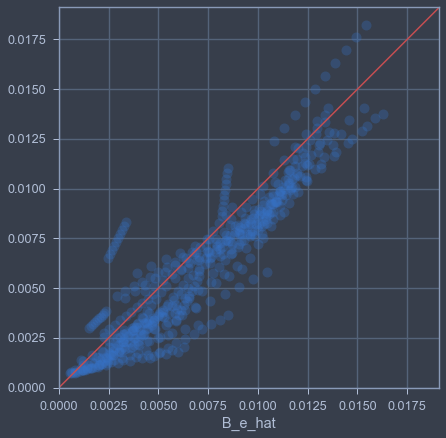

In [22]:
fig,ax=plt.subplots()
df_compare.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='o', alpha=0.30, ms=10, markeredgewidth=0)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = np.max([xlim[1],ylim[1]])
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.plot([0,lim],[0,lim],'r-')

ax.grid(True)
ax.set_aspect('equal', 'box')
ax.get_legend().remove()

In [23]:
mask = df_compare['ship_speed'] < 1
df_compare_zero_speed = df_compare.loc[mask]
df_compare_speed = df_compare.loc[~mask]


<a id='zero_speed'></a>

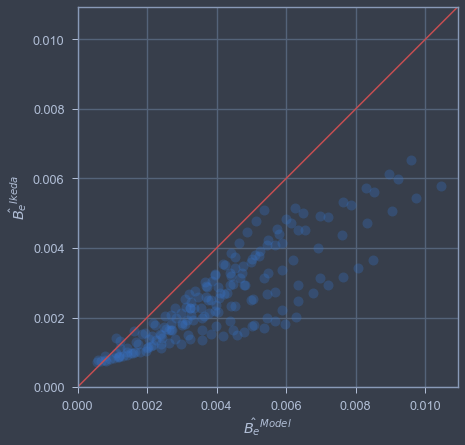

In [24]:
fig,ax=plt.subplots()
df_compare_zero_speed.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='o', alpha=0.30, ms=10, markeredgewidth=0)

ax.set_xlabel(r'$\hat{B_{e}}^{Model}$')
ax.set_ylabel(r'$\hat{B_{e}}^{Ikeda}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = np.max([xlim[1],ylim[1]])
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.plot([0,lim],[0,lim],'r-')

ax.grid(True)
ax.set_aspect('equal', 'box')
ax.get_legend().remove()

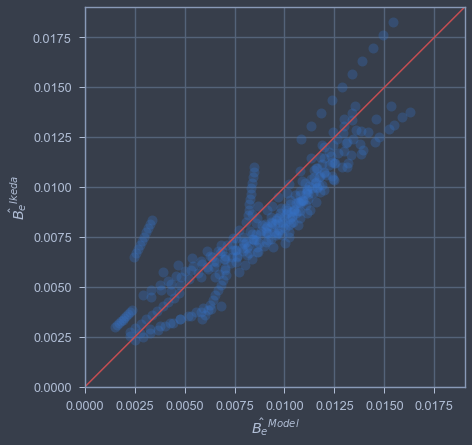

In [25]:
fig,ax=plt.subplots()
df_compare_speed.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='o', alpha=0.30, ms=10, markeredgewidth=0)

ax.set_xlabel(r'$\hat{B_{e}}^{Model}$')
ax.set_ylabel(r'$\hat{B_{e}}^{Ikeda}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = np.max([xlim[1],ylim[1]])
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.plot([0,lim],[0,lim],'r-')

ax.grid(True)
ax.set_aspect('equal', 'box')
ax.get_legend().remove()

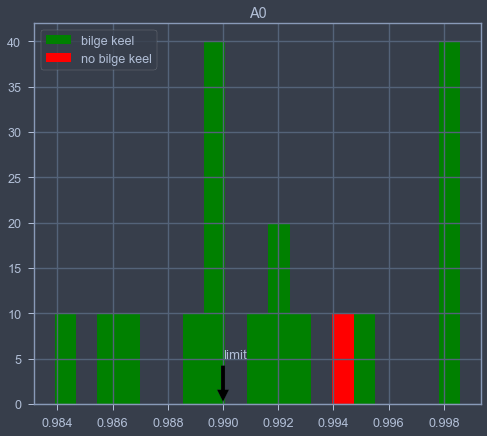

In [26]:
fig,ax=plt.subplots()

mask_bilge_keel = df_compare_zero_speed.BKL > 0

A0 = df_compare_zero_speed['A0']
bins = np.linspace(A0.min(),A0.max(),20)

df_compare_zero_speed.loc[mask_bilge_keel].hist('A0', bins=bins, ax=ax, label='bilge keel', color='green')
df_compare_zero_speed.loc[~mask_bilge_keel].hist('A0', bins=bins, ax=ax, label='no bilge keel', color='red')

ax.annotate('limit', xy=(0.99,0), xytext=(0.99,5), arrowprops=dict(facecolor='black', shrink=0.05))
ax.legend()

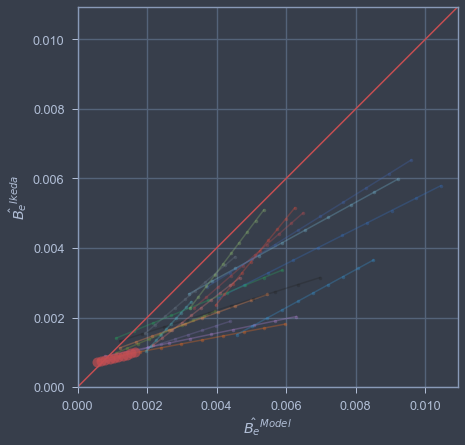

In [38]:
fig,ax=plt.subplots()
for run_id,df_ in df_compare_zero_speed.loc[mask_bilge_keel].groupby(by='id'):
    df_.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='.-', alpha=0.30)


for run_id,df_ in df_compare_zero_speed.loc[~mask_bilge_keel].groupby(by='id'):
    df_.plot(x='B_e_hat', y='B_e_hat_ikeda', ax=ax, style='ro', alpha=0.70, ms=10, markeredgewidth=0)

ax.set_xlabel(r'$\hat{B_{e}}^{Model}$')
ax.set_ylabel(r'$\hat{B_{e}}^{Ikeda}$')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = np.max([xlim[1],ylim[1]])
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.plot([0,lim],[0,lim],'r-')

ax.grid(True)
ax.set_aspect('equal', 'box')
ax.get_legend().remove()

In [39]:
df_ = df_compare_zero_speed.loc[mask_bilge_keel]
id=(df_['B_e_hat'] - df_['B_e_hat_ikeda']).abs().sort_values(ascending=False).index[0]
run_id = df_compare_zero_speed.loc[id]['id']

In [40]:
run_ids = df_compare['id'].unique()
df_ = df_rolldecay.loc[run_ids]
df_speed_variations = df_.groupby(by = 'loading_condition_id').filter(lambda x: len(x['ship_speed'].unique()) > 3)
loading_conditions = df_speed_variations.groupby(by = 'loading_condition_id').first()
#loading_conditions

c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:283: RuntimeWarning: divide by zero encountered in true_divide
  Cf = 1.328*sqrt(2*pi*visc/(3.22*r_f**2*fi_a**2*w))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:184: RuntimeWarning: invalid value encountered in true_divide
  CD = 22.5 * bBK / (pi * l * fi_a * f) + 2.4;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in true_divide
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in multiply
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:210: RuntimeWarning: invalid value encountered in true

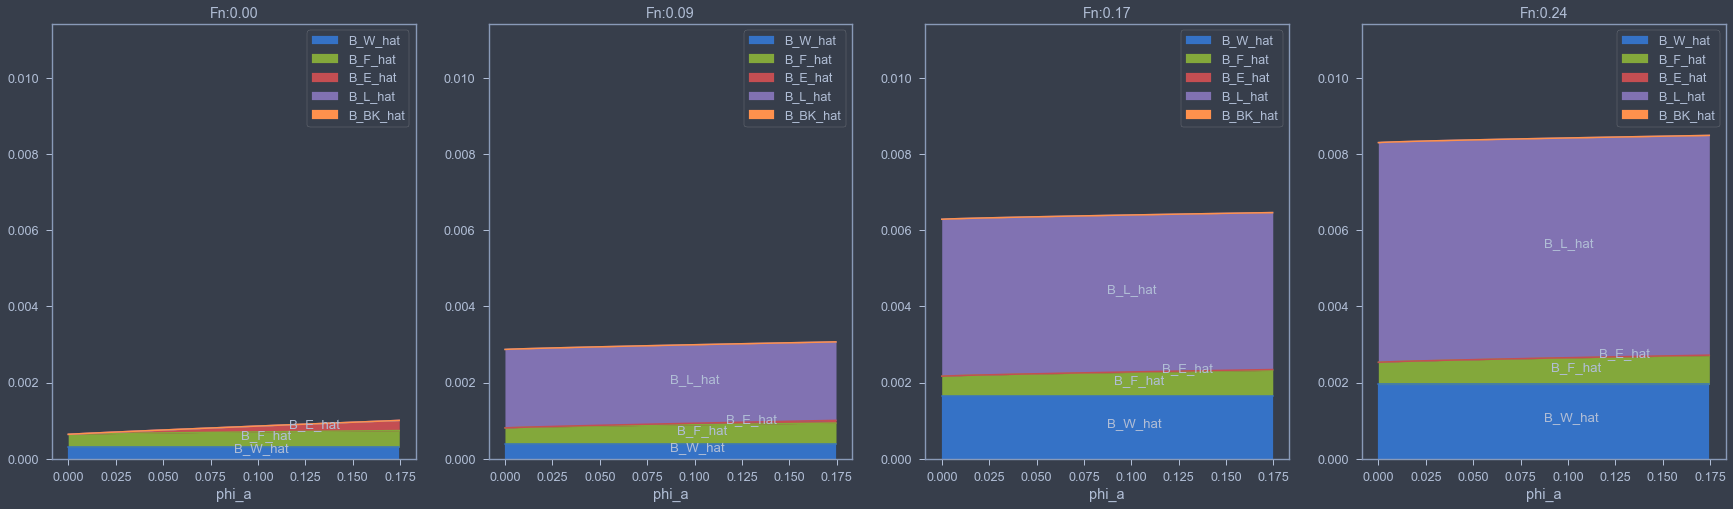

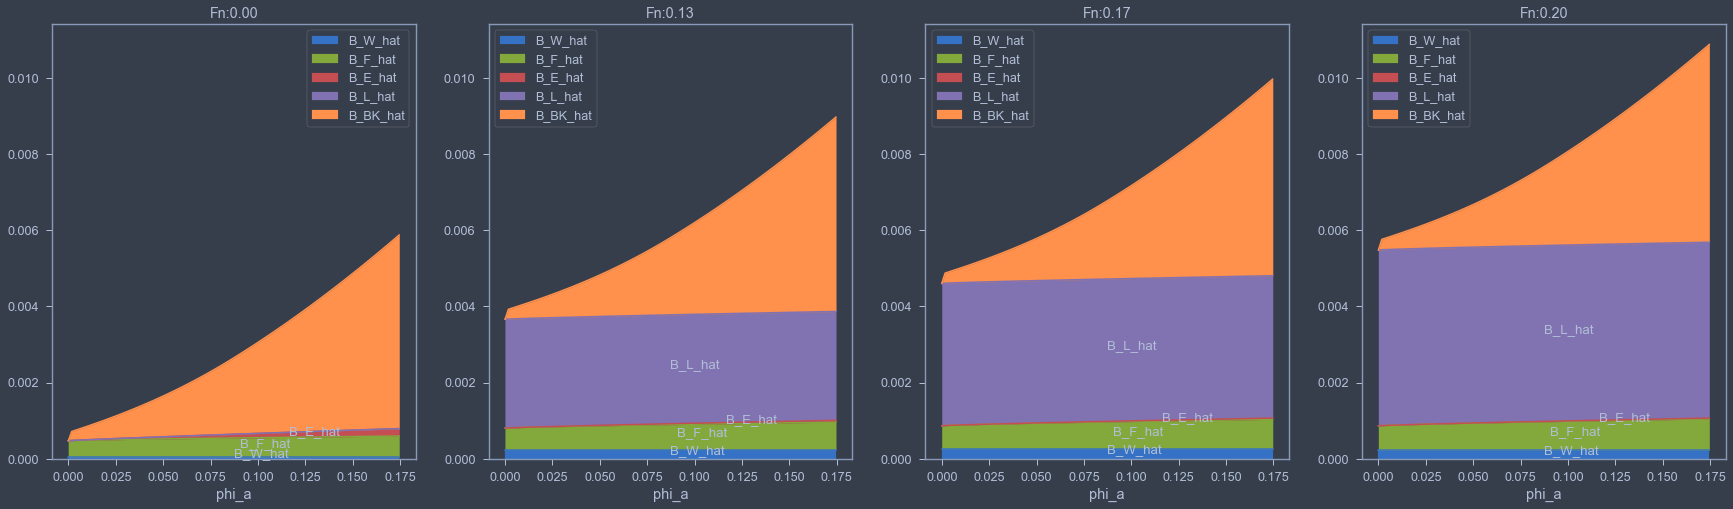

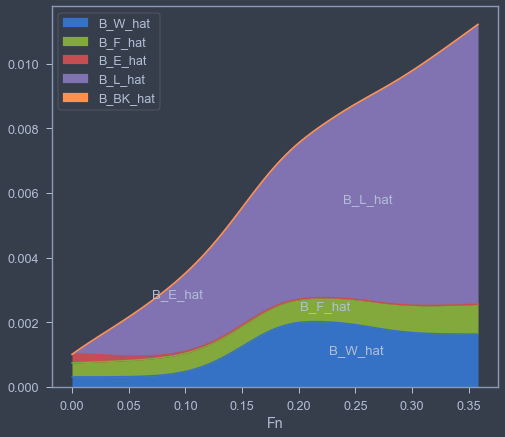

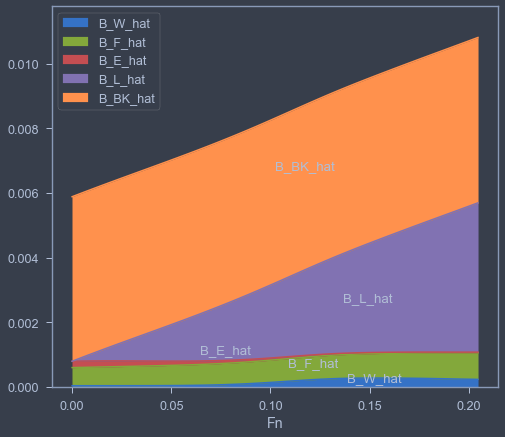

In [41]:
loading_condition_ids = [34,107]

ymaxs = []
axess = []
for loading_condition_id in loading_condition_ids:
    
    mask = df_rolldecay.loading_condition_id == loading_condition_id
    df_runs = df_rolldecay.loc[mask]
    
    run_groups = df_runs.groupby(by='Fn')
    
    fig,axes=plt.subplots(ncols=len(run_groups))
    fig.set_size_inches(30,8)
    
    ## Amplitude variation:
    for (Fn, df),ax in zip(run_groups,axes):
        
        axess.append(ax)
        
        run_id = df.iloc[0]['id']
        ikeda = deepcopy(ikedas[run_id])
        phi_as = np.deg2rad(np.linspace(0,10,100))
    
        result = ikeda.calculate(fi_a=phi_as)
        result['phi_a'] = phi_as
        result.set_index('phi_a', inplace=True)
        
        visualize.plot_area(result, ax=ax, interesting_ = ['B_W_hat', 'B_F_hat', 'B_E_hat', 'B_L_hat', 'B_BK_hat'])
        ax.set_title('Fn:%0.2f' % Fn)
    
        ylims = ax.get_ylim()
        ymaxs.append(ylims[1])
        
ymax=np.max(ymaxs)
for ax in axess:
    ax.set_ylim((0,ymax))

ymaxs = []
axess = []
for loading_condition_id in loading_condition_ids:
    
    mask = df_rolldecay.loading_condition_id == loading_condition_id
    run_id = df_rolldecay.loc[mask].index[0]
    
    ## Speed variation:
    ikeda = deepcopy(ikedas[run_id])
    phi_as = np.deg2rad([10])
    V = np.linspace(df_runs['V'].min(), df_runs['V'].max(), 100)                     
    V/=np.sqrt(ikeda.scale_factor)
    g = 9.81
    Fn = V/np.sqrt(ikeda.lpp*g)
    
    ikeda.V = V
    #ikeda.bBK = ikeda.bBK[0]*np.ones(len(V)).T
    #ikeda.lBK = ikeda.lBK[0]*np.ones(len(V)).T
    
    result = ikeda.calculate(fi_a=phi_as)
    result['Fn'] = Fn
    result.set_index('Fn', inplace=True)
    fig,ax=plt.subplots()
    axess.append(ax)
    visualize.plot_area(result, ax=ax, interesting_ = ['B_W_hat', 'B_F_hat', 'B_E_hat', 'B_L_hat', 'B_BK_hat'])
    
    ylims = ax.get_ylim()
    ymaxs.append(ylims[1])

ymax=np.max(ymaxs)
for ax in axess:
    ax.set_ylim((0,ymax))


<a id='speed'></a>

In [ ]:
print(df_runs.iloc[0].project_path)

In [ ]:
df_speed_variations = df_rolldecay.groupby(by = 'loading_condition_id').filter(lambda x: len(x) > 3)

In [ ]:
loading_conditions = df_speed_variations.groupby(by = 'loading_condition_id').first()

In [ ]:
#print(loading_conditions.loc[95].project_path)